# Importing libraries and defining useful functions

In [ ]:
%tensorflow_version 1.x
import numpy as np
import pdb
import matplotlib.pyplot as plt
import pandas  as pd
from sklearn.preprocessing import  scale
import seaborn as sns
import cv2
import os
from copy import deepcopy
from PIL import Image
from math import ceil, floor
import pickle
from google.colab import drive

#drive.mount('/content/drive')
s_directory = "drive/My Drive/Colab Notebooks/prime_project/"

TensorFlow 1.x selected.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def load_images(directory, files):
    '''Load images from disk'''
    X = []
    for img_name in files:
        img = cv2.imread(directory + img_name, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = np.array(img)
        X.append(img)
    X = np.array(X)
    return X

def get_images_wh(images):
    '''Returns a tuple of lists, representing the widths and heights of the given images, respectively.'''
    widths = []
    heights = []
    for image in images:
        h, w, rbg = image.shape
        widths.append(w)
        heights.append(h)
    return (widths, heights)

def show_image_shapes(images,n):
    '''Print the shape of n images randomly chosen'''
    for i in range(n):
        r = np.random.randint(low=0, high=len(images))
        print("image number {} has shape = {}".format(r, images[r].shape))

def show_image(image, ax = plt, title = None, show_size = False):
    '''Plots a given np.array image'''
    ax.imshow(image)
    if title:
        if ax == plt:
            plt.title(title)
        else:
            ax.set_title(title)
    if not show_size:
        ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
        
def show_images(images, titles = None, show_size = False):
    '''Plots many images from the given list of np.array images'''
    cols = 4
    f, ax = plt.subplots(nrows=int(np.ceil(len(images)/cols)),ncols=cols, figsize=(14,5))
    ax = ax.flatten()
    for i, image in enumerate(images):
        if titles:
            show_image(image, ax = ax[i], title = titles[i], show_size = show_size)
        else:
            show_image(image, ax = ax[i], title = None, show_size = show_size)
    plt.show()  

def resize_images_stretching(images,new_shape):
    """
    resize the entire data set of images
        @input
            - images: ndarray of shape=(n_images,) where each image is of shape (height,width,n_channel)
            - new_shape : a tuple (height,width)
        @returns:
            an ndarray representing the reshaped image dataset
    """
    size = (new_shape[1], new_shape[0]) # because dsize should be (width,height)
    reshaped_images = []
    for image in images:
        image = cv2.resize(src=image, dsize= size, interpolation = cv2.INTER_AREA)
        reshaped_images.append(image)  
    return np.asarray(reshaped_images)

def resize_images_padding(images, desired_size=64):
    """
    resize the entire data set of images with black padding
    in order to the aspect ratio
        @input
            - images: ndarray of shape=(n_images,) where each image is of shape (height,width,n_channel)
            - desired_size : an int
        @returns:
            an ndarray representing the reshaped image dataset
    """
    reshaped_images = []
    color = [0, 0, 0]

    for img in images:
        old_size = img.shape[:2]
        ratio = float(desired_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        img = cv2.resize(img, (new_size[1], new_size[0]))

        delta_w = desired_size - new_size[1]
        delta_h = desired_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        
        new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
        reshaped_images.append(new_img)

    return np.asarray(reshaped_images)

def reshape_stretching_padding(images, height, width, nb_channels, black_padding):
  """reshape the image data set using the dimenssions passed as argument
  @input:
   -images: ndarray of shape(n,hiegth,width,channels) representing the data set of images
   -height: integer representing the height
   -widht: integer representing the width
   -nb_channels: integer representing the number of channels
   -black_padding: boolean indicating wether to reshape using blackpadding or stretching

  @return:
  an ndarray of shape (n,ideal_heigth,ideal_width,nb_channels) representing the reshaped images 
  """
  if black_padding:
    new_shape = (height,height, 3)
    reshaped_images = resize_images_padding(images,ideal_height)
  else:
    new_shape = (height,width, 3)
    reshaped_images = resize_images_stretching(images,new_shape)
  return reshaped_images,new_shape

def serialize(obj, filename):
  outfile = open(filename,'wb')
  pickle.dump(obj,outfile)
  outfile.close()

def deserialize(filename):
  infile = open(filename,'rb')
  obj = pickle.load(infile)
  infile.close()
  return obj

# Preprocessing the original dataset

In [ ]:
!unzip -q The\ BeeImage\ Dataset\ from\ Kaggle.zip
root_path = '/content/'
directory =  root_path+"/kaggle/bee_imgs/"

In [ ]:
df = pd.read_csv(root_path+"/kaggle/bee_data.csv")
df = df[df['subspecies'] != '-1'] # remove images for which we do not have the class label
%time images = load_images(directory, df.file.values)

CPU times: user 1.08 s, sys: 167 ms, total: 1.25 s
Wall time: 1.31 s


Text(0.5, 0, 'Frequency')

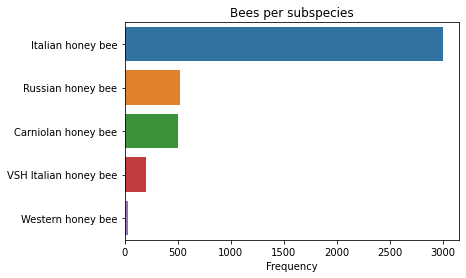

In [ ]:
labels = df.subspecies.values
unmixed_images = images[labels != "1 Mixed local stock 2"]
unmixed_labels = labels[labels != "1 Mixed local stock 2"]

unmixed_labels_df = pd.DataFrame(unmixed_labels, columns = ['unmixed_labels'])
unmixed_subspecies_counts = unmixed_labels_df['unmixed_labels'].value_counts()
plt.title("Bees per subspecies")
g = sns.barplot(x = unmixed_subspecies_counts, y = unmixed_subspecies_counts.index)
g.set_xlabel("Frequency")

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

le = LabelEncoder()
encoded_labels = le.fit_transform(unmixed_labels)
y = to_categorical(encoded_labels)

Using TensorFlow backend.


In [ ]:
best_height, best_width = 64, 56 # hard-coded height and width coming from previous EDA
black_padding = False

reshaped_images,new_shape = reshape_stretching_padding(unmixed_images, best_height, best_width, 3, black_padding)

# Building a custom model for YOLO

In [ ]:
from __future__ import print_function

import tensorflow as tf
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

import keras
from tensorflow.python.keras.backend import set_session
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping

import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
def custom_loss(y_true, y_pred):
    grid = np.array([ [[float(x),float(y)]]*nb_boxes   for y in range(grid_h) for x in range(grid_w)])

    y_true_class = y_true[...,0:nb_classes]
    y_pred_class = y_pred[...,0:nb_classes]

    pred_boxes = K.reshape(y_pred[...,nb_classes+1:], (-1,grid_w*grid_h,nb_boxes,5))
    true_boxes = K.reshape(y_true[...,nb_classes+1:], (-1,grid_w*grid_h,nb_boxes,5))
    
    y_pred_xy   = pred_boxes[...,0:2]
    y_pred_wh   = pred_boxes[...,2:4]
    y_pred_conf = pred_boxes[...,4]

    y_true_xy   = true_boxes[...,0:2]
    y_true_wh   = true_boxes[...,2:4]
    y_true_conf = true_boxes[...,4]

    clss_loss  = K.sum(K.square(y_true_class - y_pred_class), axis=-1)
    xy_loss    = K.sum(K.sum(K.square(y_true_xy - y_pred_xy),axis=-1)*y_true_conf, axis=-1)
    wh_loss    = K.sum(K.sum(K.square(K.sqrt(y_true_wh) - K.sqrt(y_pred_wh)), axis=-1)*y_true_conf, axis=-1)

    intersect_wh = K.maximum(K.zeros_like(y_pred_wh), (y_pred_wh + y_true_wh)/2 - K.square(y_pred_xy - y_true_xy) )
    intersect_area = intersect_wh[...,0] * intersect_wh[...,1]
    true_area = y_true_wh[...,0] * y_true_wh[...,1]
    pred_area = y_pred_wh[...,0] * y_pred_wh[...,1]
    union_area = pred_area + true_area - intersect_area
    iou = intersect_area / union_area

    conf_loss = K.sum(K.square(y_true_conf*iou - y_pred_conf), axis=-1)

    d = xy_loss + wh_loss + conf_loss + clss_loss
    
    if True:
        d = tf.Print(d, [d], "loss")
        d = tf.Print(d, [xy_loss], "xy_loss")
        d = tf.Print(d, [wh_loss], "wh_loss")
        d = tf.Print(d, [clss_loss], "clss_loss")
        d = tf.Print(d, [conf_loss], "conf_loss")
    
    return d

In [ ]:
nb_classes = len(unmixed_labels_df['unmixed_labels'].unique())
nb_boxes=1
grid_w=4 # 4
grid_h=4

In [ ]:
mosaic = False

if mosaic:
  height, width = best_height * grid_h, best_width * grid_w
else:
  height, width = best_height, best_width

In [ ]:
cell_h, cell_w = int(height/grid_w), int(width/grid_w)
img_w=grid_w*cell_w
img_h=grid_h*cell_h

In [ ]:
# Define the model
nb_filters = 32
kernel_size = (3, 3)
pool_size = (2, 2)

def create_model():
  i = Input(shape=(height,width,3))
  x = BatchNormalization()(i)


  x = Conv2D(
      filters = nb_filters, 
      kernel_size = kernel_size, 
      activation='relu',
      padding= "same",
      kernel_initializer = "glorot_normal", 
      name = "conv_1"
  )(x)
  x = Conv2D(
      filters = nb_filters,
      kernel_size = kernel_size,
      activation='relu',
      padding ="same",
      kernel_initializer = "glorot_normal",
      name='conv_2'
  )(x)
  x = MaxPooling2D((2, 2), name="max_pool_2")(x)
  x = Conv2D(
      filters = nb_filters,
      kernel_size = kernel_size,
      activation='relu',
      padding ="same",
      kernel_initializer= "glorot_normal",
      name='conv_3'
  )(x)
  x = MaxPooling2D((2, 2), padding="same", name = "max_pool_3")(x)

  x = Flatten()(x)
  x = Dense(256, activation='sigmoid')(x)
  x = Dense(grid_w*grid_h*(nb_classes+1+nb_boxes*5), activation='sigmoid')(x)
  x = Reshape((grid_w*grid_h,(nb_classes+1+nb_boxes*5)))(x)
  return Model(i, x)

In [ ]:
model = create_model()
adam = keras.optimizers.Adam(lr=0.001 , beta_1=0.9, beta_2=0.999) #, decay=0.01)
sgd = keras.optimizers.SGD(learning_rate=0.001, momentum=0.8, nesterov=True)
adadelta = keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07)

model.compile(loss=custom_loss, optimizer=adam)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 224, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 224, 3)       12        
_________________________________________________________________
conv_1 (Conv2D)              (None, 256, 224, 32)      896       
____________________

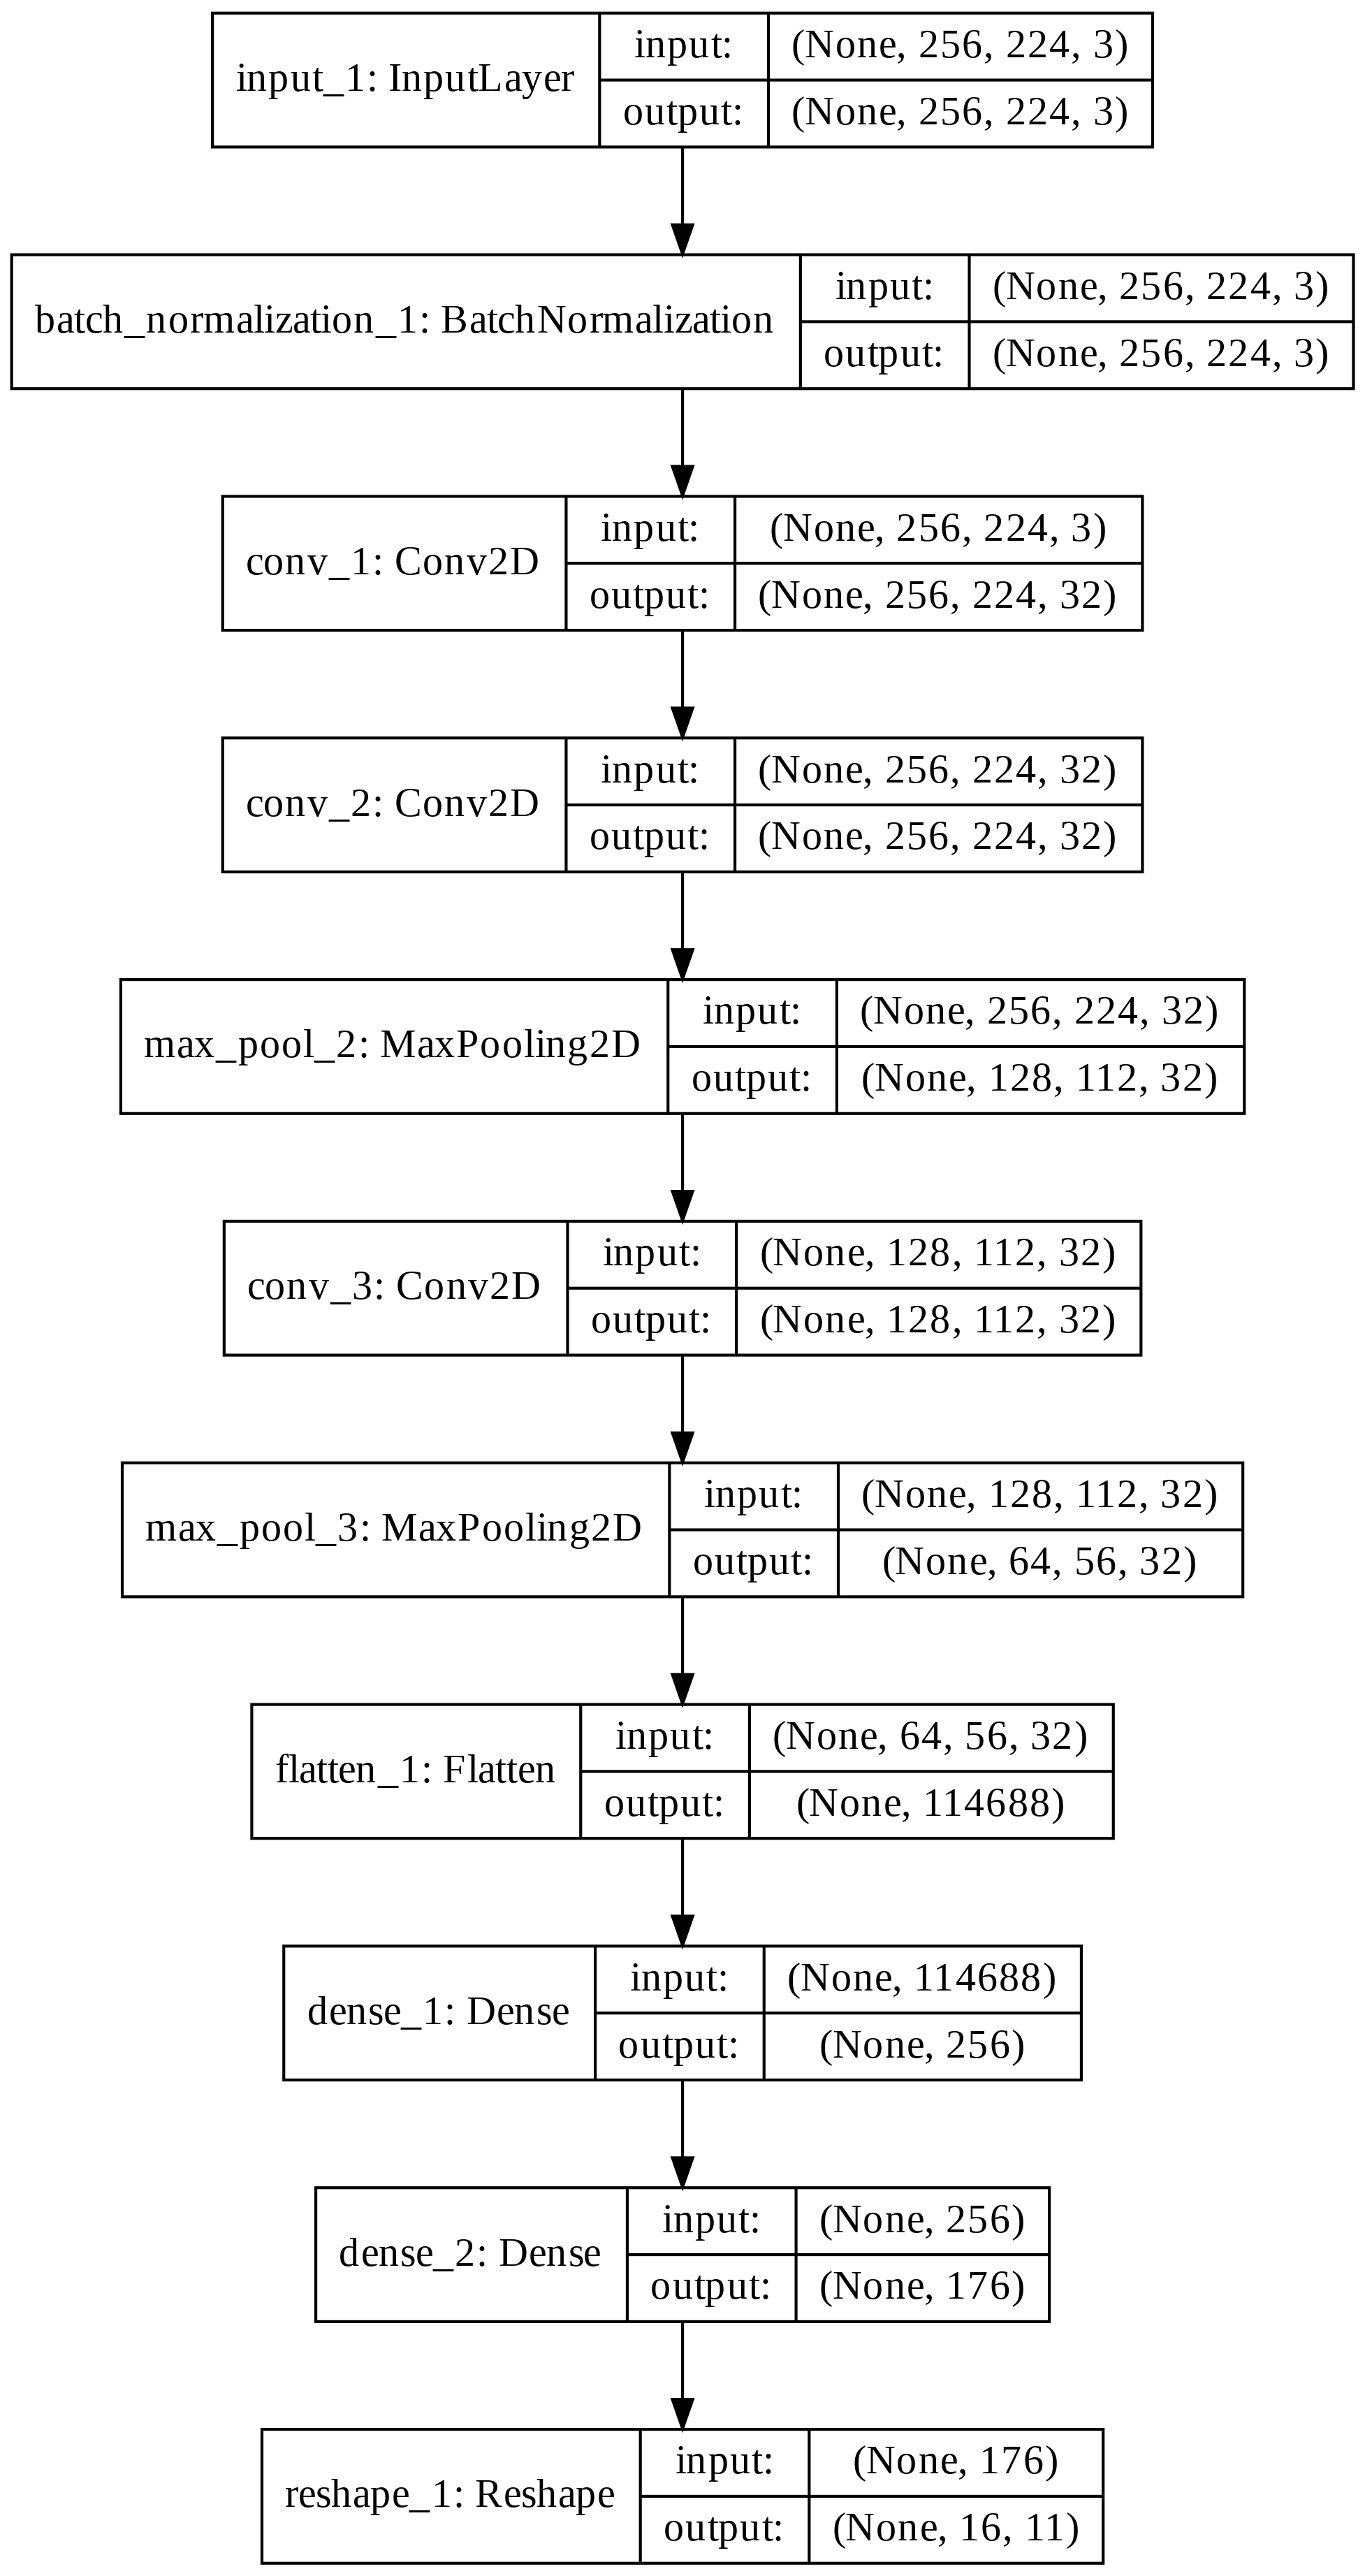

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True, dpi=300)

#Building the dataset

## Stacking

In [ ]:
mosaic_dir =  root_path+'mosaic/'
!mkdir mosaic

In [ ]:
def concat_tile(output_name, im_list, labels_list):
    vstack = []
    row = 0
    labels_file = open(mosaic_dir + output_name + ".png.txt",'w+')
    for extracted_list in im_list:
      labels = labels_list.pop(0)
      col = 0

      img_base = extracted_list[0]
      img_list = np.delete(extracted_list, 0, axis=0)

      labels_file.write(' '.join(["%d" % e for e in labels[col, :]]) + ' 0\n')
      labels_file.write('%f %f %d %d\n' % ( 0.5, 0.5, cell_w, cell_h ))
      labels_file.write('1\n') # max confidence of object

      col += 1
      for img in img_list:
        img_base = cv2.hconcat([img_base, img])

        labels_file.write(' '.join(["%d" % e for e in labels[col, :]]) + ' 0\n')        
        labels_file.write('%f %f %d %d\n' % ( 0.5, 0.5, cell_w, cell_h ))
        labels_file.write('1\n') # max confidence of object
        col += 1

      row += 1
      vstack.append(img_base)

    labels_file.write('---\n')
    labels_file.close()

    res = cv2.vconcat(vstack)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    cv2.imwrite(mosaic_dir + output_name + ".png", res)
    return

In [ ]:
for index in np.arange(0, reshaped_images.shape[0], grid_w * grid_h):
  im_list = []
  labels_list = []
  for row in range(grid_h):
    im_list.append(reshaped_images[index+(grid_w*row):index+(grid_w*(row+1))])
    labels_list.append(y[index+(grid_w*row):index+(grid_w*(row+1))])
  concat_tile(str(int(index / (grid_w * grid_h))),
              im_list,
              labels_list)

## Hand-labelling

In [ ]:
!rm /content/to_be_labeled/*
!mkdir to_be_labeled
to_be_labeled_dir = root_path + 'to_be_labeled/'

tbl_images = []
tbl_labels = []
nb_per_class = len(np.where(unmixed_labels == 'Western honey bee')[0])
random_generator = np.random.RandomState(seed = 2020)
for label in unmixed_subspecies_counts.index:
  rescued_bees = np.where(unmixed_labels == label)[0]
  indices = random_generator.choice(rescued_bees, size=nb_per_class, replace=False)
  for img in reshaped_images[indices]:
    tbl_images.append(img)
  tbl_labels += [label]*nb_per_class

tbl_images = np.array(tbl_images)
tbl_labels = np.array(tbl_labels)
print("tbl_images.shape = {}\ntbl_labels.shape = {}".format(tbl_images.shape, tbl_labels.shape))

for i in range(tbl_images.shape[0]):
  Image.fromarray(tbl_images[i]).save(to_be_labeled_dir + str(i) + "_" + str(le.transform([tbl_labels[i]])[0]+1) + ".png")

f = open(to_be_labeled_dir + "labels.txt", "w+") 
for i in range(len(le.classes_)):
  f.write(str(i+1) + " : " + le.classes_[i] + '\n')
f.close()
'''
%cd /content/to_be_labeled
!zip -r -q ../The\ BeeImage\ Dataset\ from\ Kaggle\ to_be_labeled.zip *
%cd ..
'''

mkdir: cannot create directory ‘to_be_labeled’: File exists
tbl_images.shape = (185, 256, 224, 3)
tbl_labels.shape = (185,)


'\n%cd /content/to_be_labeled\n!zip -r -q ../The\\ BeeImage\\ Dataset\\ from\\ Kaggle\\ to_be_labeled.zip *\n%cd ..\n'

In [ ]:
def convert_csv(image_dir, csv_path, y_rescale = 1, x_rescale = 1):
    csv_df = pd.read_csv(csv_path)
    box_visited = [] 
    none_label = ['0']*nb_classes
    for imagename in csv_df.image.unique():
      dict_box = {}
      for index, row in csv_df[csv_df["image"] == imagename].iterrows():
        # COLUMNS: "image", "xmin", "ymin", "xmax", "ymax", "label"
        enc_label = to_categorical(le.transform([row["label"]])[0], num_classes=nb_classes)
        box_w = int(row["xmax"] - row["xmin"]) * x_rescale
        box_h = int(row["ymax"] - row["ymin"]) * y_rescale
        y_center = int((box_h/2) + row["ymin"] * y_rescale) 
        x_center = int((box_w/2) + row["xmin"] * x_rescale)
        x_cell = floor(x_center/cell_w)
        y_cell = floor(y_center/cell_h)
        x_new = (x_center - float(x_cell * cell_w))/cell_w
        y_new = (y_center - float(y_cell * cell_h))/cell_h
        dict_box[(y_cell, x_cell)] = ' '.join(["%d" % j for j in enc_label]) + ' 0\n' + '%f %f %d %d\n' % ( x_new, y_new, box_w, box_h ) + '1\n'
    
      for y_box in range(grid_h):
        for x_box in range(grid_w):
          if (y_box, x_box) not in dict_box.keys():
            dict_box[(y_box, x_box)] = ' '.join(none_label) + ' 1\n' + '%f %f %d %d\n' % ( 0.5, 0.5, cell_w, cell_h ) + '0\n'

      dict_box = sorted(dict_box.items())
      fp_label = open(image_dir + row["image"] + ".txt", "a+")
      for filerow in dict_box:
        fp_label.write(filerow[1])
      fp_label.write('---\n')
      fp_label.close()
      
    return

In [ ]:
convert_csv(to_be_labeled_dir, "/content/labels.csv", height/best_height, width/best_width)

# Loading the dataset

In [ ]:
def load_image(imagefile):
    img = cv2.imread(imagefile)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#   img = cv2.resize(img,(64,64))
    x_t = img_to_array(img)
  #  x_t /= 255

    with open(imagefile + ".txt", "r") as f:
        y_t = []
        for row in range(grid_h):
            for col in range(grid_w):
                c_t = [float(i) for i in f.readline().split()]
                [x, y, w, h] = [float(i) for i in f.readline().split()]        
                conf_t = [float(i) for i in f.readline().split()]                
                elt = []
                elt += c_t
                for b in range(nb_boxes):
                    elt += [x, y, w/img_w, h/img_h] + conf_t
                y_t.append(elt)
        assert(f.readline()=="---\n")
        
    return [x_t, y_t]

In [ ]:
random_generator = np.random.RandomState(seed = 2020)
train_size = 0.8

if mosaic:
  nb_im = floor(reshaped_images.shape[0] / (grid_w * grid_h))
else:
  nb_im = tbl_images.shape[0]
complete_index = np.arange(0, nb_im)
train_index = random_generator.choice(complete_index, size=np.minimum(ceil(train_size * nb_im), nb_im), replace=False)
test_index = np.setxor1d(complete_index, train_index)

In [ ]:
import glob
x_data, y_data = [], []

if mosaic:
  loading_dir = mosaic_dir
else:
  loading_dir = to_be_labeled_dir
for imagefile in glob.glob(loading_dir + "*.png"):
  [x_t, y_t] = load_image(imagefile)
  x_data.append(x_t)
  y_data.append(y_t)
x_data = np.array(x_data)
y_data = np.array(y_data)

x_train = x_data[train_index]
y_train = y_data[train_index]
x_valid = x_data[test_index]
y_valid = y_data[test_index]

print("x_train.shape = {}\ny_train.shape = {}".format(x_train.shape,y_train.shape))
print("x_valid.shape = {}\ny_valid.shape = {}".format(x_valid.shape,y_valid.shape))

x_train.shape = (148, 256, 224, 3)
y_train.shape = (148, 16, 11)
x_valid.shape = (37, 256, 224, 3)
y_valid.shape = (37, 16, 11)


# Training and testing the network

In [ ]:
# Training the network
n_epochs = 5000
batch_size = ceil(x_train.shape[0]*2/3)
early_stopping = EarlyStopping(monitor='val_loss', patience=300, verbose=True, mode='min', restore_best_weights=True)

init_op = tf.global_variables_initializer()
sess.run(init_op)
with sess.as_default():
    model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_valid, y_valid), callbacks=[early_stopping], epochs=n_epochs, shuffle=True, verbose=1)
    if mosaic:
      model.save_weights(s_directory + 'mosaic_weights_our_model.h5')
    else:
      model.save_weights(s_directory + 'tbl_weights_our_model.h5')

Train on 214 samples, validate on 53 samples
Epoch 1/600
214/214 [==============================] - 44s 206ms/step - loss: 1.4095 - val_loss: 0.9327
Epoch 2/600
214/214 [==============================] - 44s 204ms/step - loss: 0.8826 - val_loss: 0.8200
Epoch 3/600
214/214 [==============================] - 45s 211ms/step - loss: 0.7650 - val_loss: 0.7317
Epoch 4/600
214/214 [==============================] - 45s 211ms/step - loss: 0.6853 - val_loss: 0.6713
Epoch 5/600
214/214 [==============================] - 44s 204ms/step - loss: 0.6239 - val_loss: 0.6263
Epoch 6/600
214/214 [==============================] - 44s 204ms/step - loss: 0.5769 - val_loss: 0.5945
Epoch 7/600
214/214 [==============================] - 44s 205ms/step - loss: 0.5423 - val_loss: 0.5742
Epoch 8/600
214/214 [==============================] - 44s 204ms/step - loss: 0.5192 - val_loss: 0.5582
Epoch 9/600
214/214 [==============================] - 43s 203ms/step - loss: 0.5031 - val_loss: 0.5478
Epoch 10/600
214/21

In [ ]:
import glob
import time
!mkdir /content/test_results/
!rm /content/test_results/*

#selector = np.arange(0, x_train.shape[0])
selector = test_index
for j in selector:
    img = x_data[j,:,:,:]
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    
    #data = img_to_array(img)
    P = model.predict(np.array([img]))
 
    # Draw each boxes and class score over each images using pyplot
    col = 0
    for row in range(grid_w):
        for col in range(grid_h):
            p = y_data[j][col*grid_h+row]
            boxes = p[nb_classes+1:].reshape(nb_boxes,5)
            clss = np.argmax(p[0:nb_classes]) # if there's class none (which is the last one in the OHE) then nb_classes-1
            imgplot = ax1.imshow(img/255)
            ax1.set_title('Ground truth')

            i = 0   
            for b in boxes:
                x = b[0]+float(row)
                y = b[1]+float(col)
                w = b[2]
                h = b[3]
                conf = b[4]
                if conf < 0.8:
                    continue 
                #print(b)
                #print([x, y, w, h])
                #print(x*cell_w-w, y*cell_h-h/2*img_h)
                color = ['red','gold','green','fuchsia','black'][clss]
                rect = patches.Rectangle((x*cell_w-w/2*img_w, y*cell_h-h/2*img_h), w*img_h, h*img_h, linewidth=2,edgecolor=color,facecolor='none')
                ax1.add_patch(rect)
                ax1.text( (x*cell_w-w/2*img_w) / img_w, 1-(y*cell_h-h/2*img_h)/img_h-i*0.15, le.inverse_transform([clss])[0] + " (%0.2f)" % (conf), transform=ax1.transAxes, color=color)
                i+=1

            p = P[0][col*grid_h+row]
            boxes = p[nb_classes+1:].reshape(nb_boxes,5)
            clss = np.argmax(p[0:nb_classes]) # if there's class none (which is the last one in the OHE) then nb_classes-1
            imgplot = ax2.imshow(img/255)
            ax2.set_title('Prediction')


            i = 0
            for b in boxes:
                x = b[0]+float(row)
                y = b[1]+float(col)
                w = b[2]
                h = b[3]
                conf = b[4]
                #print(conf, clss)
                if conf < 0.15:
                    continue 
                color = ['red','gold','green','fuchsia','black'][clss]
                rect = patches.Rectangle((x*cell_w-w/2*img_w, y*cell_h-h/2*img_h), w*img_h, h*img_h, linewidth=2,edgecolor=color,facecolor='none')
                ax2.add_patch(rect)
                ax2.text( (x*cell_w-w/2*img_w) / img_w, 1-(y*cell_h-h/2*img_h)/img_h-i*0.15, le.inverse_transform([clss])[0] + " (%0.2f)" % (conf), transform=ax2.transAxes, color=color)
                i+=1
            
    plt.savefig("/content/test_results/%d.jpg" % j, dpi=200)
    #plt.show()
    plt.close(fig)

mkdir: cannot create directory ‘/content/test_results/’: File exists


In [ ]:
%cd ./test_results
!zip -q /content/drive/My\ Drive/Colab\ Notebooks/prime_project/mosaic_test_results_our_model.zip  *
%cd ..

/content/test_results
/content


In [ ]:
%cd ./test_results
!zip -q /content/drive/My\ Drive/Colab\ Notebooks/prime_project/tbl_test_results_our_model.zip  *
%cd ..

/content/test_results
/content


# Validating the network

In [ ]:
training_ratios = [0.1, 0.2, 0.3, 0.5, 0.7, 1]
history_losses = []
history_valid_losses = []

n_epochs = 300
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=True, mode='min', restore_best_weights=True)
folds = 7

for it in range(folds):
  print("{} fold starting".format(it+1))
  train_size = 0.8
  random_generator = np.random.RandomState()
  train_index = random_generator.choice(complete_index, size=np.minimum(ceil(train_size * nb_im), nb_im), replace=False)
  test_index = np.setxor1d(complete_index, train_index)
  x_train = x_data[train_index]
  y_train = y_data[train_index]
  x_valid = x_data[test_index]
  y_valid = y_data[test_index]

  history_loss = []
  history_valid_loss = []
  for ratio in training_ratios:
    batch_size = ceil(x_train.shape[0]*ratio*2/3)
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    with sess.as_default():
      #%time history = model.fit(x_train[:ceil(x_train.shape[0]*ratio)], y_train[:ceil(y_train.shape[0]*ratio)], batch_size=batch_size, validation_data=(x_valid, y_valid), callbacks=[early_stopping], epochs=n_epochs, shuffle=True, verbose=0)
      %time history = model.fit(x_train[:ceil(x_train.shape[0]*ratio)], y_train[:ceil(y_train.shape[0]*ratio)], batch_size=batch_size, validation_data=(x_valid, y_valid), epochs=n_epochs, shuffle=True, verbose=0)
      history_loss.append(history.history['loss'])
      history_valid_loss.append(history.history['val_loss'])
  history_losses.append(history_loss)
  history_valid_losses.append(history_valid_loss)
  print("{} fold done".format(it+1))

1 fold starting
CPU times: user 3min 14s, sys: 12.6 s, total: 3min 26s
Wall time: 1min 57s
CPU times: user 4min 42s, sys: 15.3 s, total: 4min 58s
Wall time: 2min 41s
CPU times: user 6min 21s, sys: 14.8 s, total: 6min 36s
Wall time: 3min 32s
CPU times: user 9min 23s, sys: 14.5 s, total: 9min 37s
Wall time: 5min 11s
CPU times: user 12min 35s, sys: 15.3 s, total: 12min 51s
Wall time: 6min 49s
CPU times: user 17min 16s, sys: 18 s, total: 17min 34s
Wall time: 9min 24s
1 fold done
2 fold starting
CPU times: user 3min 13s, sys: 12 s, total: 3min 25s
Wall time: 1min 56s
CPU times: user 4min 41s, sys: 14.8 s, total: 4min 56s
Wall time: 2min 40s
CPU times: user 6min 19s, sys: 15 s, total: 6min 34s
Wall time: 3min 31s
CPU times: user 9min 23s, sys: 14.4 s, total: 9min 37s
Wall time: 5min 12s
CPU times: user 12min 37s, sys: 15.2 s, total: 12min 53s
Wall time: 6min 51s
CPU times: user 17min 18s, sys: 17.9 s, total: 17min 36s
Wall time: 9min 27s
2 fold done
3 fold starting
CPU times: user 3min 13s, 

In [ ]:
mean_history_losses = np.array(history_losses).mean(axis=0)
mean_history_valid_losses = np.array(history_valid_losses).mean(axis=0)
skip_first_epochs = 30

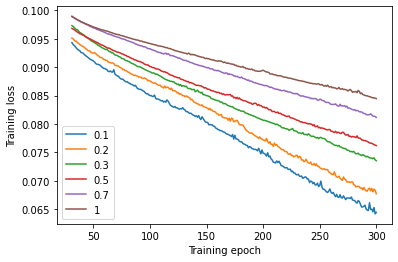

In [ ]:
for i in range(mean_history_losses.shape[0]):
  plt.plot(np.arange(skip_first_epochs+1, n_epochs+1), mean_history_losses[i, skip_first_epochs:], label=training_ratios[i])
plt.legend()
plt.xlabel('Training epoch')
plt.ylabel('Training loss')
#plt.yscale('log')
plt.savefig("/content/drive/My Drive/Colab Notebooks/prime_project/training loss per epoch.png", dpi=200)
plt.show()

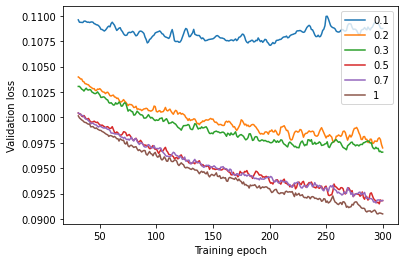

In [ ]:
for i in range(mean_history_valid_losses.shape[0]):
  plt.plot(np.arange(skip_first_epochs+1, n_epochs+1), mean_history_valid_losses[i, skip_first_epochs:], label=training_ratios[i])
plt.legend()
plt.xlabel('Training epoch')
plt.ylabel('Validation loss')
#plt.yscale('log')
plt.savefig("/content/drive/My Drive/Colab Notebooks/prime_project/validation loss per epoch.png", dpi=200)
plt.show()

In [ ]:
best_losses = np.min(mean_history_losses, axis=1)
best_valid_losses = np.min(mean_history_valid_losses, axis=1)

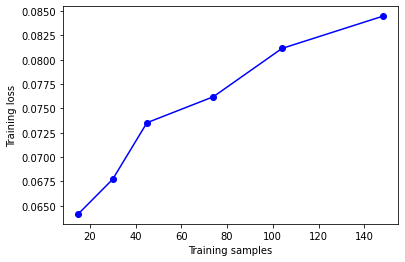

In [ ]:
plt.plot([ceil(x_train.shape[0]*ratio) for ratio in training_ratios], best_losses, 'bo-')
plt.xlabel("Training samples")
plt.ylabel("Training loss")
plt.savefig("/content/drive/My Drive/Colab Notebooks/prime_project/training loss per #samples.png", dpi=200)
plt.show()

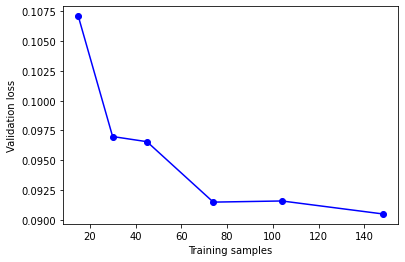

In [ ]:
plt.plot([ceil(x_train.shape[0]*ratio) for ratio in training_ratios], best_valid_losses, 'bo-')
plt.xlabel("Training samples")
plt.ylabel("Validation loss")
plt.savefig("/content/drive/My Drive/Colab Notebooks/prime_project/validation loss per #samples.png", dpi=200)
plt.show()